In [102]:
import os
import re
import json
from datetime import datetime
from typing import TypedDict
from langchain_core.output_parsers import StrOutputParser
from pymongo import MongoClient
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

In [103]:
client = MongoClient('mongodb://localhost:27017/')
db = client["student_records"]
sales_collection = db["students"]

In [104]:
# Load environment variables
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [105]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

In [106]:
class State(TypedDict):
    question: str
    mongo_pipeline: str
    parsed_pipeline: list
    query_results: list
    answer: str
    error: str
    retry_count: int

In [107]:
def clean_mongo_query(query: str) -> str:
    return re.sub(r"```json|```", "", query.strip(), flags=re.IGNORECASE)

In [108]:
# Parse MongoDB pipeline and convert date strings to JSON dates
def parse_mongo_pipeline(pipeline_str: str) -> list:
    def convert_dates(obj):
        if isinstance(obj, dict):
            for key, value in obj.items():
                if isinstance(value, str) and re.match(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z", value):
                    try:
                        dt = datetime.strptime(value, "%Y-%m-%dT%H:%M:%SZ")
                        obj[key] = dt
                    except ValueError:
                        pass
                else:
                    convert_dates(value)
        elif isinstance(obj, list):
            for item in obj:
                convert_dates(item)
        return obj

    try:
        pipeline = json.loads(pipeline_str)
        return convert_dates(pipeline)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid pipeline JSON: {e}\nPipeline: {pipeline_str}")

In [109]:
from langchain.prompts import PromptTemplate

mongo_prompt = PromptTemplate.from_template(
    """You are an AI agent that generates MongoDB queries for a database with a collection named "students".

Each student document has the following fields:
- name (string)
- student_id (string)
- department (string)
- cgpa (float)
- graduation_year (integer)

Your task is to convert the user's natural language question into a valid MongoDB **filter query** for use with `.find()`.

Question: {question}

Return only the JSON-style query object using Python syntax (e.g., {{ "cgpa": {{ "$gt": 3.5 }} }}).

Do NOT return Mongo shell syntax, aggregation pipelines, or markdown — only the Python dictionary filter object.
"""
)



answer_prompt = PromptTemplate.from_template(
    """You are given the results of a MongoDB query and a user question.

Question: {question}

Query Results:
{results}

Instructions:
- For each matching student, extract the following:
  - Name
  - Department
  - CGPA
  - Graduation Year
- Format as a clean, numbered list.
- Include **all** students from the results — do not skip or summarize.
- If no results are found, return: "No data found for the query."
- Return only the final list. Do not include any prefix like "Answer:" or extra explanation.
"""
)





In [110]:
def generate_pipeline(state: State) -> State:
    try:
        mongo_chain = mongo_prompt | llm | StrOutputParser() | clean_mongo_query
        mongo_pipeline = mongo_chain.invoke({"question": state["question"]})
        print(f"\nGenerated MongoDB Pipeline:\n{mongo_pipeline}")
        return {"mongo_pipeline": mongo_pipeline}
    except Exception as e:
        return {"error": f"Error generating pipeline: {e}"}

In [111]:
def execute_query(state: State) -> State:
    if state.get("error"):
        return state
    try:
        parsed_pipeline = parse_mongo_pipeline(state["mongo_pipeline"])
        print(f"\nParsed MongoDB Pipeline:\n{parsed_pipeline}")

        doc_count = sales_collection.count_documents({})
        print(f"Sales collection document count: {doc_count}")

        # Determine query type and fetch data
        if isinstance(parsed_pipeline, list):
            results = list(sales_collection.aggregate(parsed_pipeline))
        elif isinstance(parsed_pipeline, dict):
            results = list(sales_collection.find(parsed_pipeline))
        else:
            return {"error": f"Parsed pipeline is neither list nor dict: {type(parsed_pipeline)}"}

        total_results = len(results)

        # Display matched document count
        print(f"Matched document count: {total_results}")

        # Display results accordingly
        if total_results == 0:
            print("\nMongoDB Results: No documents found.")
        elif total_results <= 3:
            print(f"\nMongoDB Results ({total_results} document{'s' if total_results > 1 else ''}):")
            print(json.dumps(results, default=str, indent=2))
        else:
            print(f"\nMongoDB Results (showing 3 of {total_results} documents):")
            print(json.dumps(results[:3], default=str, indent=2))

        return {"parsed_pipeline": parsed_pipeline, "query_results": results}
    except Exception as e:
        return {"error": f"Error executing query: {e}"}



def process_query(question: str) -> str:
    inputs = {"question": question, "retry_count": 0}
    final_state = None
    for output in agent.stream(inputs):
        final_state = output

    # final_state structure might be nested because of StateGraph and node names
    # Let's safely extract answer:
    if final_state is None:
        return "No answer generated"
    
    # Check keys for answer
    if "format_answer" in final_state and isinstance(final_state["format_answer"], dict):
        return final_state["format_answer"].get("answer", "No answer generated")
    if "answer" in final_state:
        return final_state["answer"]
    if "error" in final_state:
        return final_state["error"]

    return "No answer generated"


In [112]:
def format_answer(state: State) -> State:
    if state.get("error"):
        return {"answer": state["error"]}
    try:
        results_str = json.dumps(state["query_results"], default=str, indent=2)
        answer_chain = answer_prompt | llm | StrOutputParser()
        answer = answer_chain.invoke({
            "question": state["question"],
            "results": results_str
        })
        return {"answer": answer}
    except Exception as e:
        return {"answer": f"Error formatting answer: {e}"}


In [113]:
graph = StateGraph(State)
graph.add_node("generate_pipeline", generate_pipeline)
graph.add_node("execute_query", execute_query)
graph.add_node("format_answer", format_answer)
graph.set_entry_point("generate_pipeline")
graph.add_conditional_edges(
    "generate_pipeline",
    lambda state: "execute_query" if not state.get("error") else "format_answer",
    {"execute_query": "execute_query", "format_answer": "format_answer"}
)
graph.add_conditional_edges(
    "execute_query",
    lambda state: "format_answer" if not state.get("error") else "format_answer",
    {"format_answer": "format_answer"}
)
graph.add_edge("format_answer", END)

agent = graph.compile()

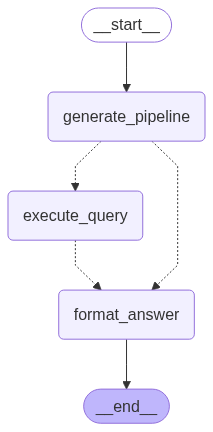

In [114]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [115]:
def process_query(question: str) -> str:
    inputs = {"question": question, "retry_count": 0}
    final_state = None
    for output in agent.stream(inputs):
        final_state = output  
    if 'format_answer' in final_state and 'answer' in final_state['format_answer']:
        return final_state['format_answer']['answer']
    return final_state.get('error', 'No answer generated')



In [116]:
def main():
    queries = [
        "Show me all students with CGPA above 3.5",
        "List students graduating in 2025",
        "Get details of student with ID 20231234",
        "Who are the students in the CSE department?",
        "How many students have CGPA less than 2.5?"
    ]
    for query in queries:
        print(f"\nQuery: {query}")
        response = process_query(query)
        print(f"\nResponse: {response}")

if __name__ == "__main__":
    main()


Query: Show me all students with CGPA above 3.5

Generated MongoDB Pipeline:
{ "cgpa": { "$gt": 3.5 } }

Parsed MongoDB Pipeline:
{'cgpa': {'$gt': 3.5}}
Sales collection document count: 10
Matched document count: 4

MongoDB Results (showing 3 of 4 documents):
[
  {
    "_id": "6892d0532cc205bb50fa50bc",
    "name": "Clara Lee",
    "student_id": "20231232",
    "department": "Mechanical Engineering",
    "cgpa": 3.91,
    "graduation_year": 2025
  },
  {
    "_id": "6892d0532cc205bb50fa50bd",
    "name": "David Kim",
    "student_id": "20231233",
    "department": "Computer Science",
    "cgpa": 3.67,
    "graduation_year": 2024
  },
  {
    "_id": "6892d0532cc205bb50fa50c0",
    "name": "Grace Liu",
    "student_id": "20231236",
    "department": "Physics",
    "cgpa": 3.6,
    "graduation_year": 2024
  }
]

Response: 1. Clara Lee
   - Department: Mechanical Engineering
   - CGPA: 3.91
   - Graduation Year: 2025

2. David Kim
   - Department: Computer Science
   - CGPA: 3.67
   - Gra